In [1]:
using LinearAlgebra
using Random
using Plots
using Printf

In [2]:
function sample_data(r, points, shift)
    rad = rand(points) * 2 * pi
    random1, random2 = rand(points), rand(points)
    x_shift = @. (random1 * 2 - 1) * shift
    y_shift = @. (random2 * 2 - 1) * shift
    x = @. (cos(rad) + x_shift) * r
    y = @. (sin(rad) + y_shift) * r
    return x, y
end

sample_data (generic function with 1 method)

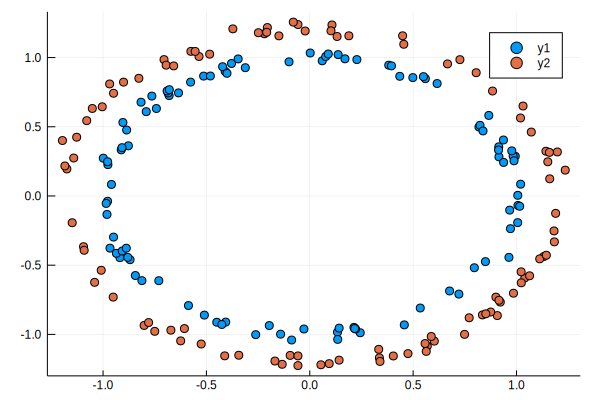

In [3]:
x1, y1 = sample_data(1, 100, 0.05)
x2, y2 = sample_data(1.2, 100, 0.05)
scatter(x1, y1)
scatter!(x2, y2)

In [4]:
sigmoid(z) = @. 1 / (1 + exp(-z))
d_sigmoid(z) = @. (1 - sigmoid(z)) * sigmoid(z)
relu(z) = @. z * (z > 0)
d_relu(z) = @. 1 * (z > 0)
active(z, activation) = activation == "relu" ? relu(z) : sigmoid(z)
d_active(z, activation) = activation == "relu" ? d_relu(z) : d_sigmoid(z)

d_active (generic function with 1 method)

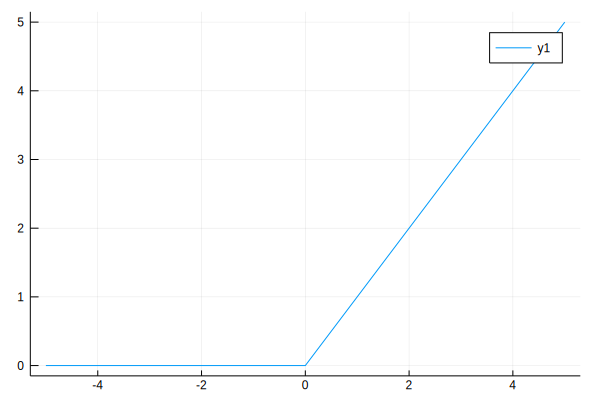

In [5]:
plot(relu, -5:0.1:5)

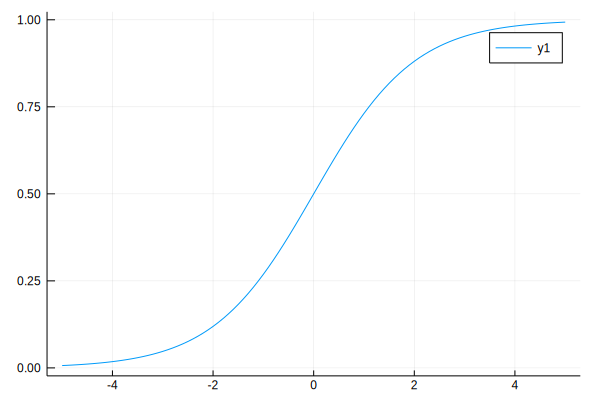

In [6]:
plot(sigmoid, -5:0.1:5)

In [7]:
function forward_propagation(X, W, B, activations)
    A, Z, a = [], [], X
    for l in 1:length(activations)
        z = W[l] * a .+ B[l]
        a = active(z, activations[l])
        Z = [Z..., z]
        A = [A..., a]
    end
    return Z, A
end

cost(Y_hat, Y) = sum(@. -Y * log(Y_hat) - (1 - Y) * log(1 - Y_hat))/length(Y)

function backward_propagation(X, Y, W, B, Z, A, activations)
    n, m = size(X)
    L = length(activations)
    a = A[L]
    da = @. (a - Y) / (1-a) / a / m
    dA, dW, dB = [da,], [], []
    for l in L:-1:1
        w, z, a = W[l], Z[l], A[l]
        a_pre = l==1 ? X : A[l - 1]
        da = dA[1]
        dz = da .* d_active(z, activations[l])
        da_pre = w' * dz
        dw = dz * a_pre'
        db = sum(dz, dims=2)
        dA = l==1 ? dA : [da_pre, dA...]
        dW = [dw, dW...]
        dB = [db, dB...]
    end
    return dA, dW, dB
end

function gradient_descent!(W, B, dW, dB, layers, learning_rate=0.01)
    for l in 1:layers
        W[l] = @. W[l] - learning_rate * dW[l]
        B[l] = @. B[l] - learning_rate * dB[l]
    end
end

function train_data!(X, Y, W, B, activations; iterations=3000, learning_rate=0.01, threshold=0.5)
    costs = []
    L = length(activations)
    for i in 1:iterations
        Z, A = forward_propagation(X, W, B, activations)
        dA, dW, dB = backward_propagation(X, Y, W, B, Z, A, activations)
        gradient_descent!(W, B, dW, dB, L, learning_rate)
        c = cost(A[L], Y)
        costs = [costs..., c]
        Y_pre = @. (A[L] >= threshold) * 1 
        accuracy = sum(Y_pre .== Y)/length(Y)
        print("cost=$(@sprintf("%.6f", c)), accuracy=$accuracy " * (i==iterations ? "" : "\r"))
    end
    predict = (x1, x2) -> let W = copy(W), B = copy(B), activations = copy(activations)
        Z, A = forward_propagation([x1, x2], W, B, activations)
        (A[length(activations)][1] >= threshold) * 1
    end
    return costs, predict
end

train_data! (generic function with 1 method)

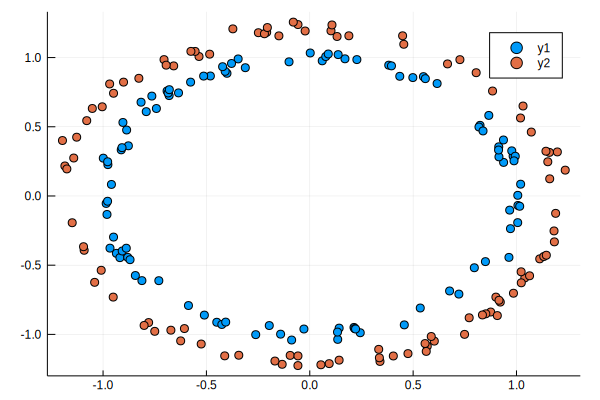

In [8]:
X = [[x1'; y1'] [x2'; y2']]
Y = [zeros(1, 100) ones(1, 100)]
random_order = randperm(200)
X = X[:, random_order]
Y = Y[:, random_order]
negative_index = [Y...].==0
positive_index = [Y...].==1
scatter(X[:, negative_index][1, :], X[:, negative_index][2, :])
scatter!(X[:, positive_index][1, :], X[:, positive_index][2, :])

In [57]:
W1 = randn(8, 2)
b1 = randn(8, 1)
W2 = randn(8, 8)
b2 = randn(8, 1)
W3 = randn(1, 8)
b3 = randn(1, 1)

1×1 Array{Float64,2}:
 -0.45484060305737894

In [58]:
W = [W1, W2, W3]
B = [b1, b2, b3]
activations = ["relu", "relu", "sigmoid"]
@time costs, predit = train_data!(X, Y, W, B, activations, iterations = 6000, learning_rate=0.05)
nothing

cost=0.005556, accuracy=1.0   1.705284 seconds (18.86 M allocations: 1.568 GiB, 13.56% gc time)


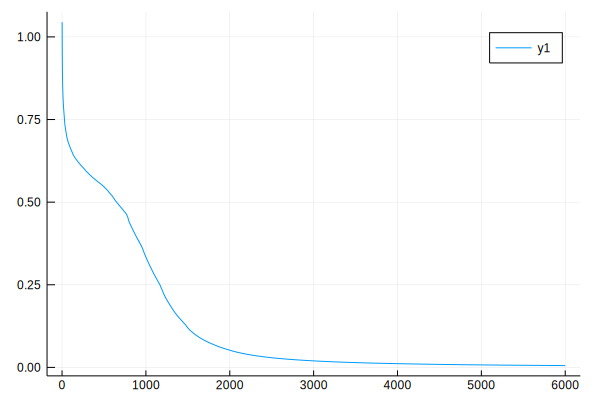

In [59]:
plot(1:length(costs), costs)

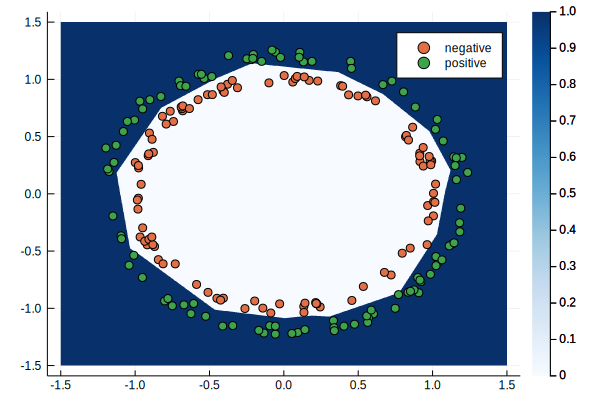

In [60]:
x = -1.5:0.002:1.5
Z = predit.(x, x')
contour(x, x, Z, fill=true, fillcolor=:Blues)
scatter!(x1, y1, label="negative")
scatter!(x2, y2, label="positive")

In [61]:
W = [W1, W2, W3]
B = [b1, b2, b3]
activations = ["sigmoid", "sigmoid", "sigmoid"]
@time costs, bad_predit = train_data!(X, Y, W, B, activations, iterations=6000, learning_rate=0.05)
nothing

cost=0.645801, accuracy=0.585   3.544891 seconds (18.86 M allocations: 1.568 GiB, 10.58% gc time)


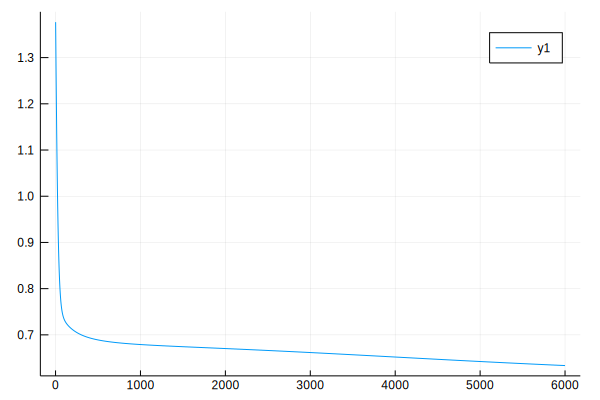

In [55]:
plot(1:length(costs), costs)

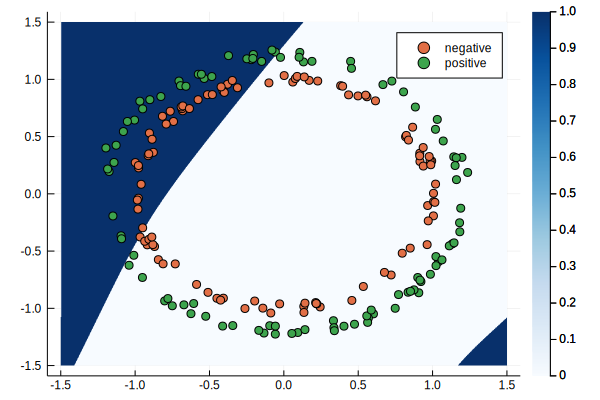

In [56]:
x = -1.5:0.002:1.5
Z = bad_predit.(x, x')
contour(x, x, Z, fill=true, fillcolor=:Blues)
scatter!(x1, y1, label="negative")
scatter!(x2, y2, label="positive")